**Analysis of Olfaction EEG Pilot Data**

- The file 'data.cnt' contains EEG data from a dog exposed to green tea and black tea odors.
- Extract meaningful features, and train a machine learning model to distinguish between the neural signatures associated with each scent.

In [2]:
# Import necessary libraries

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import scipy


***1. Dataset description***

In [3]:
# Load Dataset

file_path = 'data.cnt'
raw = mne.io.read_raw_cnt(file_path, preload=True)

Reading 0 ... 1256399  =      0.000 ...  1256.399 secs...


C:\Users\Naveen\AppData\Local\Temp\ipykernel_11500\3246103811.py:4: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw = mne.io.read_raw_cnt(file_path, preload=True)


In [4]:
# Basic information
raw.info

<Info | 10 non-empty values
 bads: 1 items (Trigger)
 ch_names: F7, Fz, F8, FCz, A1, Cz, Trigger
 chs: 7 EEG
 custom_ref_applied: False
 dig: 10 items (3 Cardinal, 7 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>

In [5]:
# Channel names
raw.ch_names

['F7', 'Fz', 'F8', 'FCz', 'A1', 'Cz', 'Trigger']

In [6]:
raw.describe()

<RawCNT | data.cnt, 7 x 1256400 (1256.4 s), ~67.1 MB, data loaded>
ch  name     type  unit        min         Q1     median         Q3        max
 0  F7       EEG   µV    -10234.17   -7589.14   -5788.53   -2203.62    6947.11
 1  Fz       EEG   µV     71406.31   87619.91   96683.83  101007.52  107002.55
 2  F8       EEG   µV     11822.91   12858.49   13351.56   13732.19   16582.37
 3  FCz      EEG   µV     53966.57   55960.91   81001.24   84467.75   85837.45
 4  A1       EEG   µV        41.42    2222.25    6612.90    9985.50   15256.14
 5  Cz       EEG   µV     24111.10   25016.38   25396.87   25962.02   27206.59
 6  Trigger  EEG   µV         0.00       0.00       0.00       0.00       0.00


In [7]:
raw.to_data_frame().head(3)

,time,F7,Fz,F8,FCz,A1,Cz,Trigger
0,0.000,-9837.630986,71416.626054,11844.385522,84361.348671,14614.569359,25846.767232,0.0
1,0.001,-9833.307004,71419.405600,11837.244686,84351.432271,14616.761315,25847.516145,0.0
2,0.002,-9839.660709,71415.289992,11831.163731,84352.560203,14607.514128,25845.707793,0.0


In [8]:
print(f'Time duration : {round(raw.times[-1]/60,2)} min ' )

Time duration : 20.94 min 


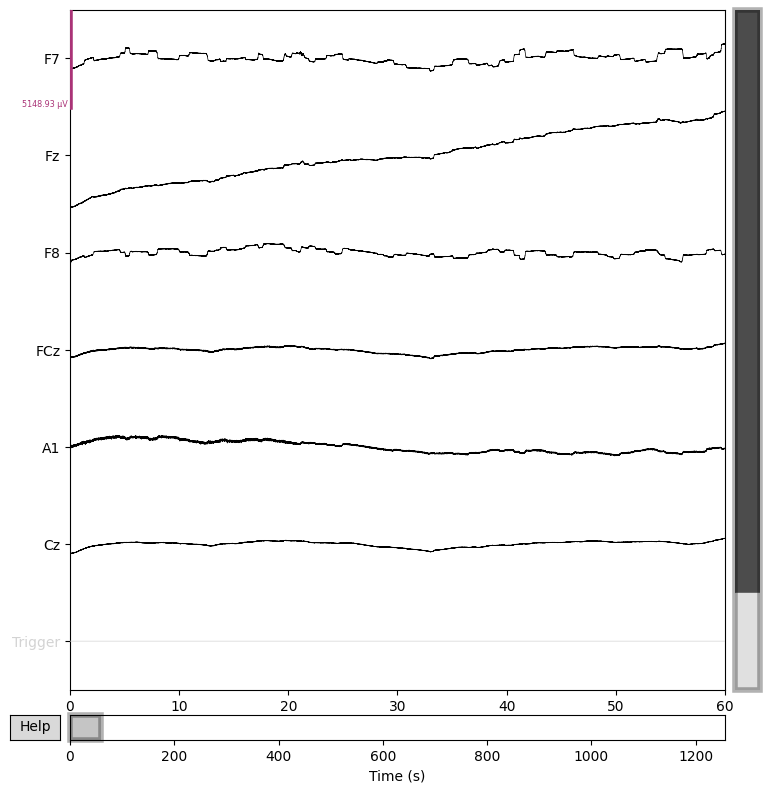

In [10]:
# Plot the raw EEG data
raw.plot(n_channels=7, duration=60, scalings='auto')
plt.show()

***2. Signal Processing and analysis***

In [11]:
# Check missing values
# Get the raw data as a numpy array
data, times = raw[:, :]

# Check for NaNs in the data
n_missing = np.isnan(data).sum()
print(f"Number of missing values: {n_missing}")


Number of missing values: 0


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)


c:\Users\Naveen\anaconda3\envs\myenv\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
c:\Users\Naveen\anaconda3\envs\myenv\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


Channel Labels: ['F7', 'Fz', 'F8', 'FCz', 'A1', 'Cz', 'Trigger']


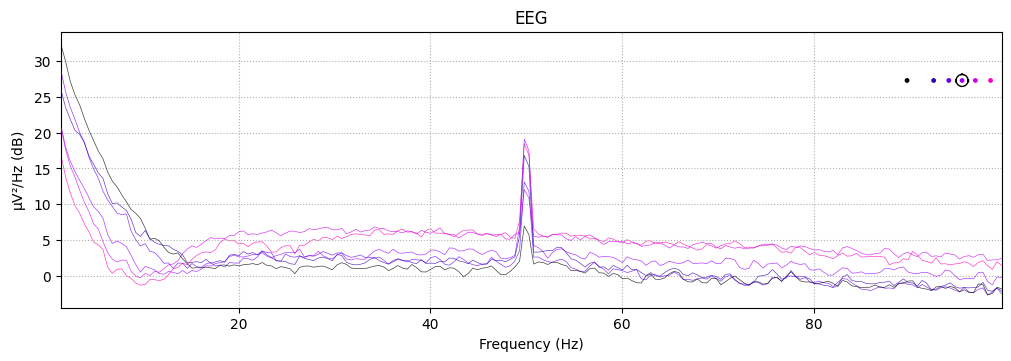

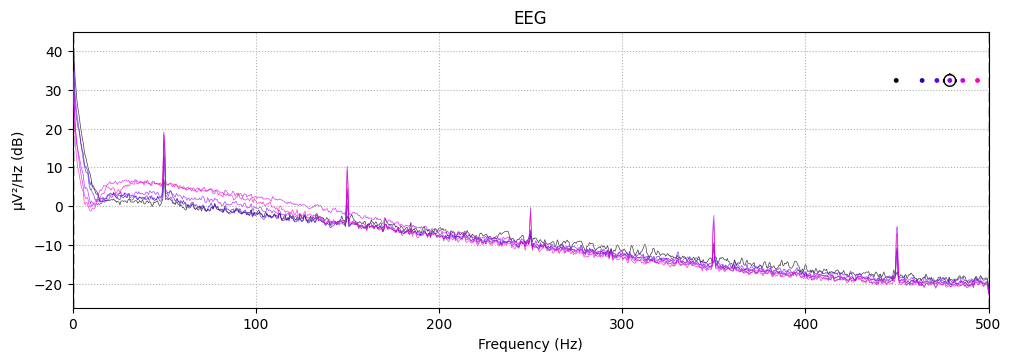

In [12]:
# Analyze PSD from EEG data

# Plot the power spectral density (PSD) of the raw data
raw.plot_psd(fmin=1.0, fmax=100.0)
raw.plot_psd()
    
# Show the labels of the channels
channel_labels = raw.info['ch_names']
print("Channel Labels:", channel_labels)
    
# Show the plot
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)


c:\Users\Naveen\anaconda3\envs\myenv\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


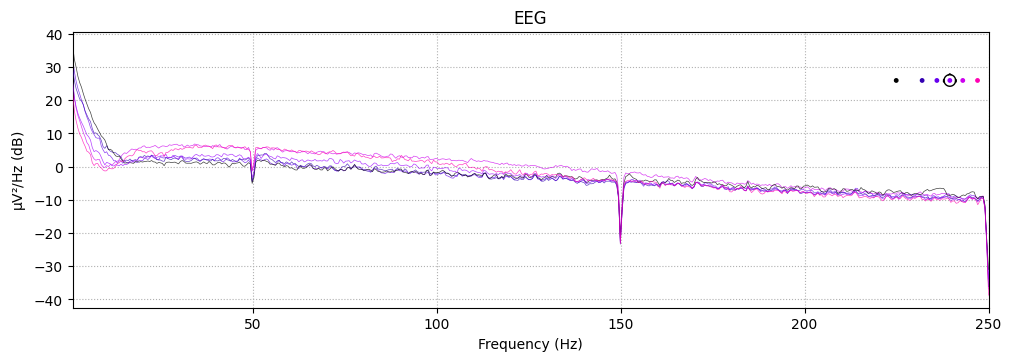

In [13]:
# Apply notch filtering at 50 Hz and its harmonics (100 Hz, 150 Hz, etc.)
freqs_to_notch = [50,150,250,350,450]  
raw.notch_filter(freqs=freqs_to_notch, fir_design='firwin')

# Plot the PSD again to verify the effect of the notch filter
raw.plot_psd(fmin=0.5, fmax=250)
plt.show()

***2.1 Segmenting the EEG data into epochs***

In [14]:
# Load the experimental data segments

data_segment1 = pd.read_csv("experiment_data_segment_1.csv")
data_segment2 = pd.read_csv("experiment_data_segment_2.csv")

print(data_segment1.head())
print("\n", data_segment2.head())

  Condition    Clock Time  Experiment Time
0         N  1.693234e+09         2.006433
1         G  1.693234e+09         6.028522
2         C  1.693234e+09        10.050210
3         N  1.693234e+09        14.071487
4         G  1.693234e+09        18.088619

   Condition    Clock Time  Experiment Time
0         N  1.693235e+09       663.705117
1         G  1.693235e+09       667.726120
2         C  1.693235e+09       671.746673
3         G  1.693235e+09       675.762022
4         N  1.693235e+09       679.782310


In [15]:
# Merge the two experimental data segments
experimental_data = pd.concat([data_segment1, data_segment2])
experimental_data.shape

(180, 3)

In [16]:
# Extract eventsand create a list of events in the format expected by MNE

event_mapping = {'N': 0, 'G': 1, 'C': 2}
experimental_data['Event'] = experimental_data['Condition'].map(event_mapping)

# Create a list of events in the format expected by MNE
events = []
for i, row in experimental_data.iterrows():
    event_time = int(row['Experiment Time'] * raw.info['sfreq'])
    events.append([event_time, 0, row['Event']])

events = np.array(events)
events[:5]

array([[ 2006,     0,     0],
       [ 6028,     0,     1],
       [10050,     0,     2],
       [14071,     0,     0],
       [18088,     0,     1]])

In [18]:
# Define event IDs
event_id = {'green_tea': 1, 'black_tea': 2}

# Extract epochs
epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=4, baseline=(None, 0), preload=True) # tmax modified to contain pre stimular, stimulus and post stimulus

Not setting metadata
120 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 4201 original time points ...
0 bad epochs dropped


In [19]:
epochs.info

<Info | 10 non-empty values
 bads: 1 items (Trigger)
 ch_names: F7, Fz, F8, FCz, A1, Cz, Trigger
 chs: 7 EEG
 custom_ref_applied: False
 dig: 10 items (3 Cardinal, 7 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>

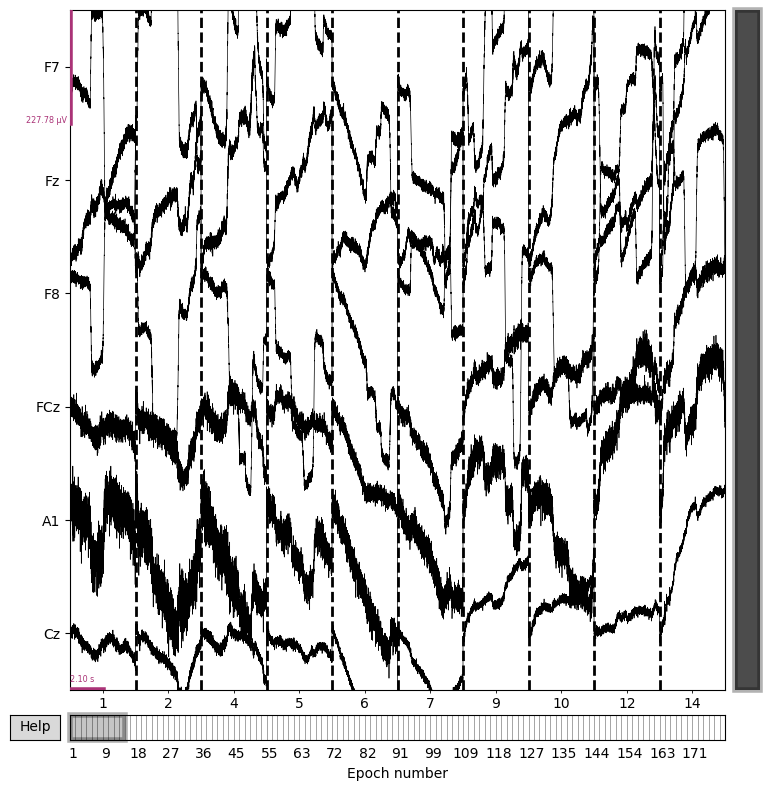

In [20]:
epochs.plot(scalings='auto',n_epochs=10)
plt.show()

In [21]:
epochs.to_data_frame()

,time,condition,epoch,F7,Fz,F8,FCz,A1,Cz,Trigger
0,-0.200,green_tea,1,1.255451,-7.271688,4.834008,7.454289,-25.978063,-9.076751,0.0
1,-0.199,green_tea,1,0.275063,-3.202602,3.369152,9.650040,-18.949373,-6.465766,0.0
2,-0.198,green_tea,1,-0.824745,-10.757677,-1.072055,9.334754,-12.580770,-3.042598,0.0
3,-0.197,green_tea,1,-2.516053,-16.364475,-2.368610,1.442908,-6.317538,-4.565384,0.0
4,-0.196,green_tea,1,3.418839,-16.176214,-0.939598,0.188295,-1.723308,-5.000664,0.0
...,...,...,...,...,...,...,...,...,...,...
504115,3.996,black_tea,178,103.966307,96.421429,57.439337,127.033841,97.753337,39.085897,0.0
504116,3.997,black_tea,178,94.593396,94.827453,61.035332,127.796330,102.385839,38.648998,0.0
504117,3.998,black_tea,178,91.489696,95.242295,63.261715,128.071872,98.137195,39.916212,0.0
504118,3.999,black_tea,178,94.259862,97.308478,62.120622,132.275815,96.700495,42.695615,0.0


Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


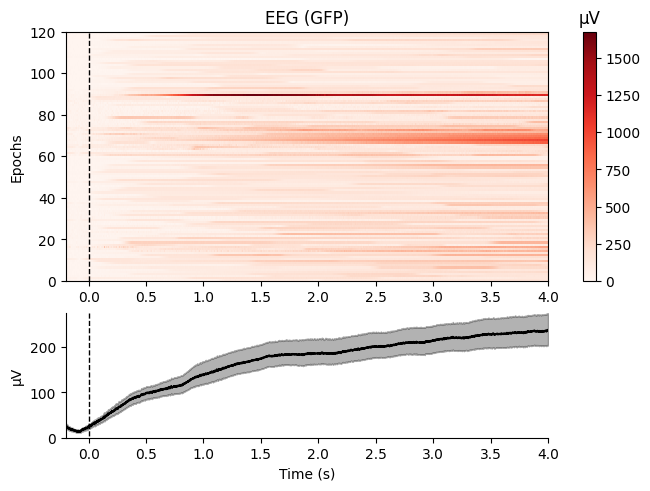

In [22]:
epochs.plot_image()
plt.show()

Inferences:

Amplitude Variation: There is a noticeable pattern in the epochs, where amplitudes increase significantly after the event marker (0 s). This could indicate a strong evoked response due to the stimulus associated with the event.

Baseline Period: The period before the event marker (from -0.2 s to 0 s) is generally used as a baseline to compare post-stimulus changes. It looks relatively stable, which is good for baseline correction.

In [23]:
epochs.save('data/preprocessed_epochs.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


C:\Users\Naveen\AppData\Local\Temp\ipykernel_11500\261730676.py:1: RuntimeWarning: This filename (data/preprocessed_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save('data/preprocessed_epochs.fif', overwrite=True)


***2.2 Data processing steps***

In [24]:
# Band-pass filtering to focus on specific frequency bands, e.g., 0.2-80 Hz
epochs.filter(0.2, 80., fir_design='firwin') 

Setting up band-pass filter from 0.2 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 16501 samples (16.501 s)



C:\Users\Naveen\AppData\Local\Temp\ipykernel_11500\298471625.py:2: RuntimeWarning: filter_length (16501) is longer than the signal (4201), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(0.2, 80., fir_design='firwin')
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.5s


Number of events,120
Events,black_tea: 60green_tea: 60
Time range,-0.200 – 4.000 s
Baseline,-0.200 – 0.000 s


In [25]:
# Epoch artifact rejection
reject_criteria = dict(eeg=1000e-6)  # 1000 µV
epochs.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['F7', 'Fz', 'F8', 'FCz', 'A1', 'Cz']
2 bad epochs dropped


Number of events,118
Events,black_tea: 60green_tea: 58
Time range,-0.200 – 4.000 s
Baseline,-0.200 – 0.000 s


In [26]:
# Artifact Rejection
from mne.preprocessing import ICA

# Initialize ICA
ica = ICA(n_components=6, random_state=97)
ica.fit(epochs)

# No EOG, ECG Channel

Fitting ICA to data using 6 channels (please be patient, this may take a while)


C:\Users\Naveen\AppData\Local\Temp\ipykernel_11500\3895476960.py:6: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Selecting by number: 6 components
Fitting ICA took 4.4s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,34 iterations on epochs (495718 samples)
ICA components,6
Available PCA components,6
Channel types,eeg
ICA components marked for exclusion,—


In [27]:
# Apply the ICA solution to the epochs
epochs_clean = epochs.copy()
ica.apply(epochs_clean)

Applying ICA to Epochs instance
    Transforming to ICA space (6 components)
    Zeroing out 0 ICA components
    Projecting back using 6 PCA components


C:\Users\Naveen\AppData\Local\Temp\ipykernel_11500\1516012881.py:3: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs_clean)


Number of events,118
Events,black_tea: 60green_tea: 58
Time range,-0.200 – 4.000 s
Baseline,-0.200 – 0.000 s


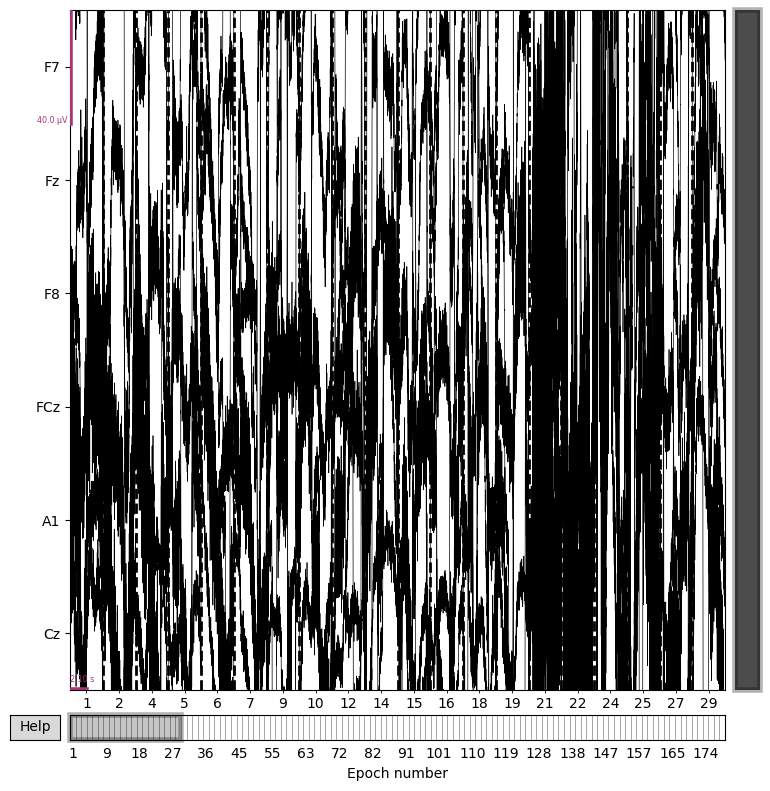

In [28]:
epochs_clean.plot()
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


c:\Users\Naveen\anaconda3\envs\myenv\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


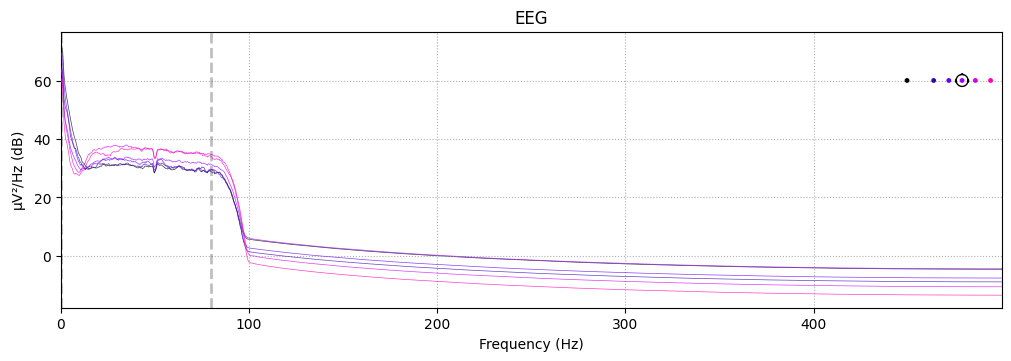

In [29]:
# Plot the power spectral density for the epochs
epochs_clean.plot_psd()
plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


c:\Users\Naveen\anaconda3\envs\myenv\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


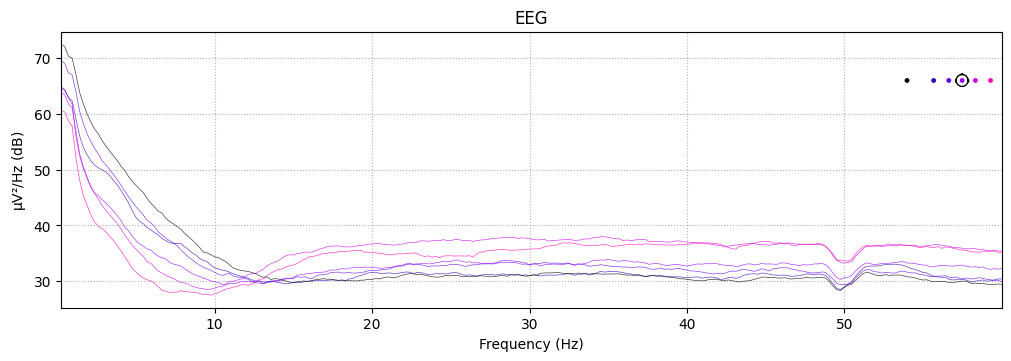

In [30]:
# Plot the power spectral density for the epochs (high freq)
epochs_clean.plot_psd(fmin=0.2, fmax=60)
plt.show()

Inferences:

1. The plot shows a significant drop in power as the frequency increases, which is typical for EEG data where most of the energy is concentrated in the lower frequency bands 

2. Notable Peaks: There seem to be peaks around 50 Hz and its harmonics (e.g., 100 Hz, 150 Hz, etc.), which are likely due to electrical line noise. Filtered the peaks from raw data

In [31]:
# Check excessive variance or outliers
# Calculate variance across epochs for each channel
variances = np.var(epochs_clean.get_data(), axis=2)
mean_variances = np.mean(variances, axis=0)
std_variances = np.std(variances, axis=0)

# Identify channels with variances significantly higher than the mean
outlier_channels = np.where(mean_variances > mean_variances.mean() + 2 * std_variances)[0]
print("Outlier Channels:", outlier_channels)

Outlier Channels: []


C:\Users\Naveen\AppData\Local\Temp\ipykernel_11500\3484408709.py:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  variances = np.var(epochs_clean.get_data(), axis=2)


***2.3 Event Related potentials (ERPs)***

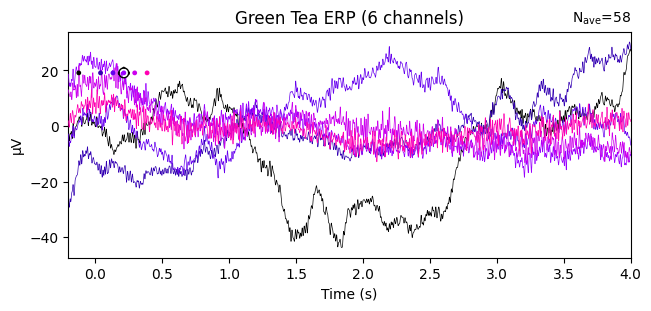

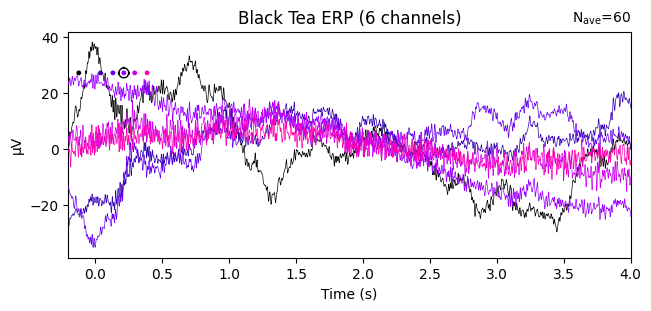

In [32]:
# Compute the average ERP for each condition
evoked_green_tea = epochs_clean['green_tea'].average()
evoked_black_tea = epochs_clean['black_tea'].average()

# Plot the ERPs
evoked_green_tea.plot(titles='Green Tea ERP',picks='all')
evoked_black_tea.plot(titles='Black Tea ERP',picks='all')
plt.show()

In [33]:
epochs_clean.info['ch_names']

['F7', 'Fz', 'F8', 'FCz', 'A1', 'Cz', 'Trigger']

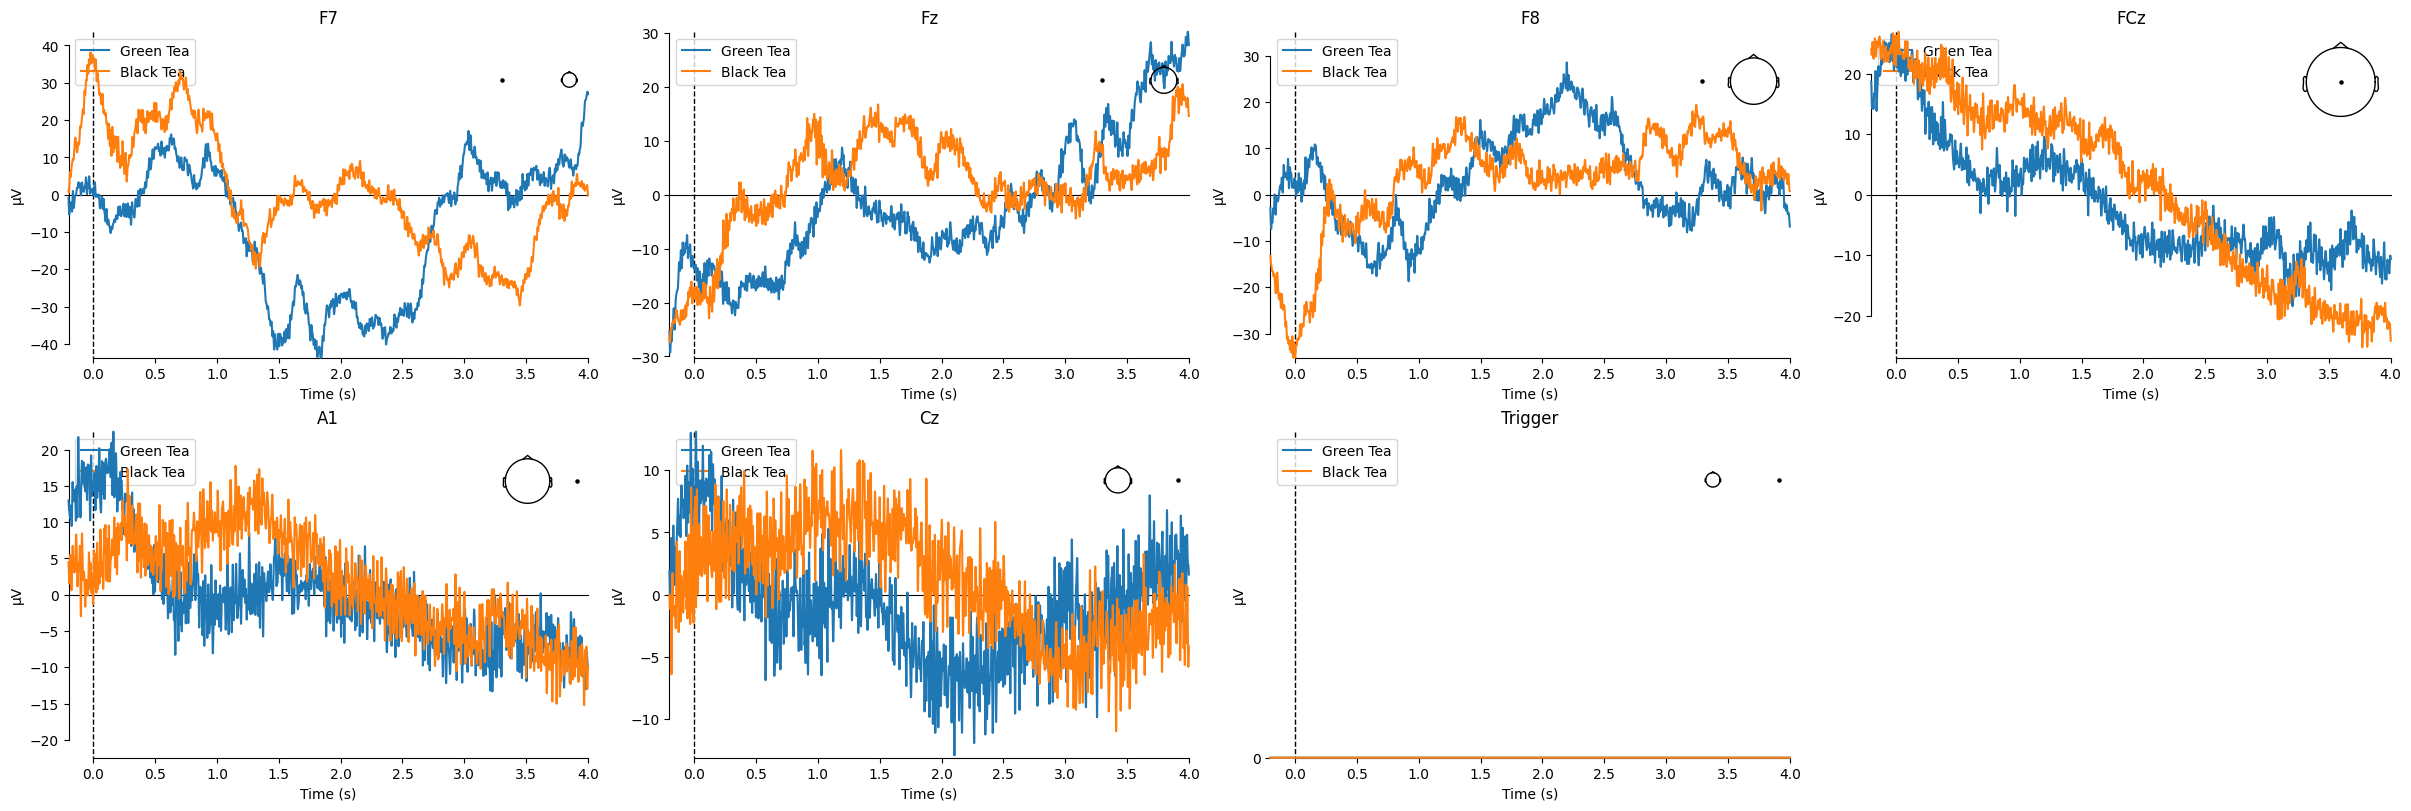

In [34]:
# layout for subplots
n_channels = len(evoked_green_tea.info['ch_names'])
n_cols = 4  
n_rows = int(np.ceil(n_channels / n_cols))

# Increase the figure size (each subplot size)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), constrained_layout=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each channel in a subplot
for ch_idx in range(n_channels):
    mne.viz.plot_compare_evokeds(
        {
            'Green Tea': evoked_green_tea,
            'Black Tea': evoked_black_tea
        },
        picks=ch_idx,
        axes=axes[ch_idx],
        show_sensors='upper right',
        legend='upper left',
        show=False  # Turn off showing plot to prevent interruption in loop
    )
    axes[ch_idx].set_title(evoked_green_tea.ch_names[ch_idx])

for ax in axes[n_channels:]:
    ax.set_visible(False)

# Show the entire figure
plt.show()

ERP analysis and inferences:

1. Differential Responses: The ERP responses for "Green Tea" and "Black Tea" across the channels exhibit variable amplitude differences, which may indicate differential brain processing associated with each odor.

    Notably, channels like F7, F8, and FCz show distinct patterns where the amplitude of the response varies significantly between the two conditions around certain time points.


2. Event-related Potential Onset: All channels show a clear response shortly after the event trigger (time = 0). This typical ERP feature is a good indicator that the stimuli are effectively evoking neural responses.


3. Potential Cognitive Implications: The frontal channels (F7, F8, Fz, and FCz) are particularly interesting as they show noticeable differences in response patterns between the two teas. Given that these areas are involved in decision-making and sensory integration, the differences might reflect cognitive processing or sensory discrimination aspects.


4. Temporal Dynamics: The response patterns vary over time, with some channels showing a more pronounced initial peak (e.g., within 0.5 seconds post-stimulus), which might be associated with initial sensory processing.
Other channels show sustained activity patterns that might be linked to continued cognitive processing or integration of the sensory information.


5. Signal Noise and Clarity: Channels like A1 show a lot of variability and noise in the signal, which could either reflect true physiological variability or potential residual noise/artifacts not fully removed during preprocessing.

No baseline correction applied


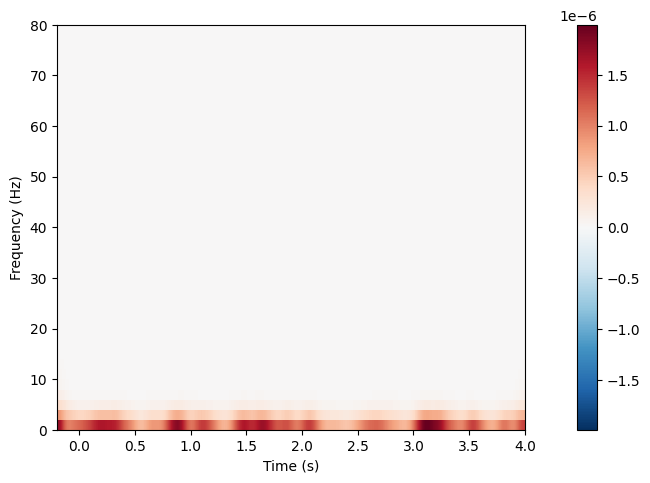

In [36]:
# Time frequency analysis

from mne.time_frequency import tfr_morlet

# Define frequencies and compute time-frequency decomposition
frequencies = np.arange(1, 80, 2)  # 1 to 80 Hz in steps of 2 Hz
n_cycles = frequencies / 2
power = tfr_morlet(epochs_clean, freqs=frequencies, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3)

# Plot the results
power.plot([0])  
plt.show()

Applying baseline correction (mode: logratio)


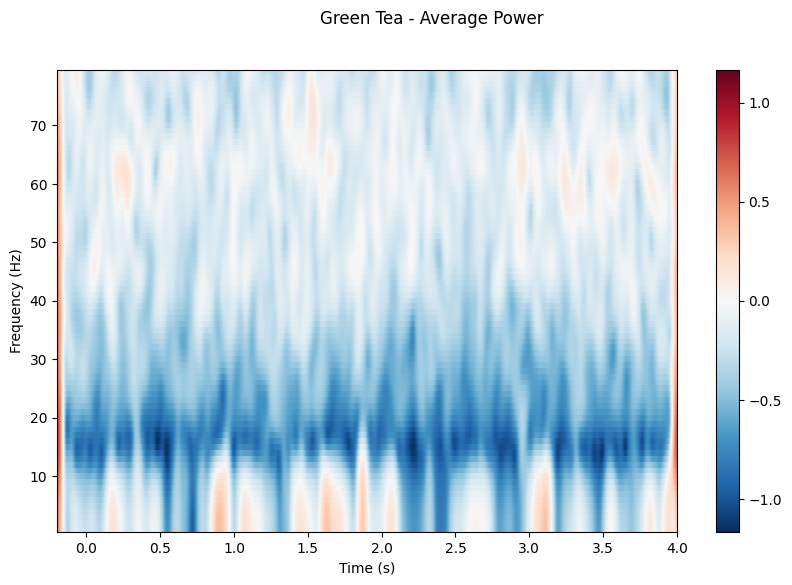

Applying baseline correction (mode: logratio)


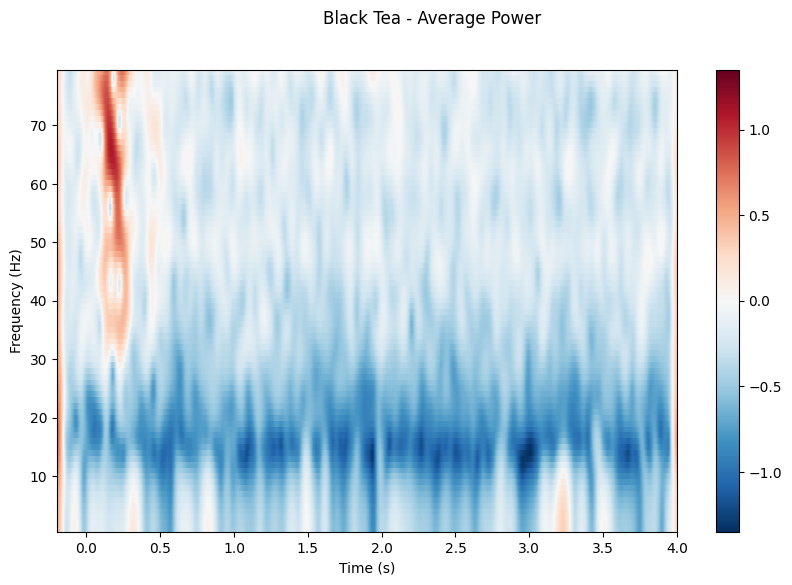

In [37]:
# Analyzing time-frequency components for each condition

# Create separate epochs for each condition
epochs_green_tea = epochs_clean['green_tea']
epochs_black_tea = epochs_clean['black_tea']


# Define frequencies of interest
frequencies = np.arange(1, 80, 1)  # Frequencies from 1 to 80 Hz
n_cycles = frequencies / 5.  # Adjust the number of cycles

# Compute TFR for green tea epochs
power_green_tea = tfr_morlet(epochs_green_tea, freqs=frequencies, n_cycles=n_cycles, return_itc=False, average=True)

# Compute TFR for black tea epochs
power_black_tea = tfr_morlet(epochs_black_tea, freqs=frequencies, n_cycles=n_cycles, return_itc=False, average=True)

# Plot TFR for green tea
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
power_green_tea.plot([0], baseline=(-0.2, 0), mode='logratio', title='Green Tea - Average Power', axes=ax)
ax.set_facecolor('white')

# Plot TFR for black tea
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
power_black_tea.plot([0], baseline=(-0.2, 0), mode='logratio', title='Black Tea - Average Power', axes=ax)
ax.set_facecolor('white')
plt.show()

Inferences: 

1. Prominent Low-Frequency Activation: There is a noticeable increase in power in the lower frequency bands (below 10 Hz) immediately after the stimulus onset, persisting throughout the observation period.


2. Delta and Theta Bands Involvement: The increase in power is predominantly in the delta and theta frequency bands, which are often associated with initial sensory processing and attentional mechanisms in cognitive tasks.

3. Sustained Neural Engagement: The continued elevated activity in these lower frequencies suggests sustained neural engagement, likely related to ongoing cognitive processes such as recognition, evaluation, or memory encoding.

4. Minimal High-Frequency Activity: The plot shows minimal activity in higher frequencies (above 20 Hz), indicating that the task may not require high cognitive demands or complex information processing typically associated with higher frequency bands.

5. Insight into Neural Dynamics: This analysis provides valuable insights into the neural dynamics elicited by the stimulus, highlighting the timing and nature of brain activity across different frequency bands during task processing.

6. Comparative analysis for each stimuli: Higher frequency bands engaged with the onset of black tea stimul. Lower frequency bands actively engaging and increasing over time with the onset of green tea stimuli

In [38]:
# Statistical analysis
# Extract data arrays for each condition from the epochs

from mne.stats import permutation_cluster_test

green_tea_data = epochs_clean['green_tea'].get_data()
black_tea_data = epochs_clean['black_tea'].get_data()

# Stack the data into a list of arrays
X = [green_tea_data, black_tea_data]

# Configure the statistical test
# None uses a t-threshold by default, which is derived from p<0.05 under the assumption of a normal distribution
threshold = None
n_permutations = 1000  # Number of permutations to compute

# Perform the cluster-based permutation test
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(X, n_permutations=n_permutations, threshold=1.5, tail=0)

stat_fun(H1): min=nan max=nan
Running initial clustering …
Found 256 clusters


C:\Users\Naveen\AppData\Local\Temp\ipykernel_11500\3749188455.py:6: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  green_tea_data = epochs_clean['green_tea'].get_data()
C:\Users\Naveen\AppData\Local\Temp\ipykernel_11500\3749188455.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  black_tea_data = epochs_clean['black_tea'].get_data()
c:\Users\Naveen\anaconda3\envs\myenv\lib\site-packages\mne\stats\parametric.py:174: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\Naveen\AppData\Local\Temp\ipykernel_11500\3749188455.py:18: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(X, n_permutations=n_permutations, threshold=1.5, tail=0)
c:\Users\Naveen\anaconda3\envs

In [39]:
# Print significant clusters
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        print(f"Cluster {i+1}: Significant with p-value {p_val:.4f}")
    else:
        pass

In [40]:
# Focus on a specific time window and channels
time_window = (0., 2.)  # time window in seconds
channels = ['F7', 'F8', 'FCz']  # channels where differences were noted
indices = [epochs_clean.ch_names.index(ch) for ch in channels]
tmin_idx = int((time_window[0] - epochs_clean.tmin) * epochs_clean.info['sfreq'])
tmax_idx = int((time_window[1] - epochs_clean.tmin) * epochs_clean.info['sfreq'])

# Extract data within this window and for these channels
X_focused = [d[:, indices, tmin_idx:tmax_idx] for d in X]

In [41]:

# Run the cluster-based permutation test
threshold = None  
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
    X_focused,
    n_permutations=1000,
    threshold=threshold,
    tail=0  # Use 0 for two-tailed test
)

Using a threshold of 3.922879
stat_fun(H1): min=0.000000 max=6.052070
Running initial clustering …
Found 8 clusters


C:\Users\Naveen\AppData\Local\Temp\ipykernel_11500\3005143176.py:3: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
100%|██████████| Permuting : 999/999 [00:03<00:00,  257.33it/s]


In [42]:
# Print the results
for i, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        print(f"Significant cluster {i+1} with p-value {p_val:.4f}")
    else:
        pass

In [121]:
# Connectivity analysis
pass

In [43]:
epochs_clean.to_data_frame()['Trigger'].unique()

array([0.])

In [44]:
epochs_clean.drop_channels(['Trigger'])

print(epochs_clean.info['ch_names'])

['F7', 'Fz', 'F8', 'FCz', 'A1', 'Cz']


***3. Feature Extraction***

***3.1 Time domain statistical features***

In [45]:
def extract_time_domain_features(data):
    """
    Extract time-domain features from EEG data.
    :param data: np.array, EEG data array (n_epochs, n_channels, n_times)
    :return: np.array, extracted features
    """
    mean = np.mean(data, axis=2)
    std_dev = np.std(data, axis=2)
    skewness = scipy.stats.skew(data, axis=2)
    kurtosis = scipy.stats.kurtosis(data, axis=2)
    # Stack features along the last axis
    features = np.stack([mean, std_dev, skewness, kurtosis], axis=-1)
    return features

***3.2 Frequency domain features***

In [49]:
def extract_frequency_domain_features(data, sfreq):
    """
    Extract frequency-domain features from EEG data for specific frequency bands.
    :param data: np.array, EEG data array (n_epochs, n_channels, n_times)
    :param sfreq: float, sampling frequency
    :return: np.array, features extracted for each frequency band
    """
    # Define frequency bands
    bands = {'delta': (0.2, 4),
             'theta': (4, 8),
             'alpha': (8, 12),
             'beta': (12, 30),
             'gamma': (30, 80)}

    # Initialize a list to hold the band powers
    band_powers = []

    # Compute the power spectral density using multitaper
    psds, freqs = mne.time_frequency.psd_array_multitaper(data, sfreq=sfreq, fmin=0.2, fmax=60, adaptive=True, normalization='full')

    # Loop through defined bands and extract features
    for band, (fmin, fmax) in bands.items():
        # Find indices of frequencies in the specified range
        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        # Calculate mean PSD in the band, and append it to the list
        band_power = psds[:, :, freq_mask].mean(axis=2)
        band_powers.append(band_power)

    # Stack band powers along the last axis to form feature array
    features = np.stack(band_powers, axis=-1)  # Shape will be (n_epochs, n_channels, n_bands)
    return features

***3.3 Wavelet feature extraction***

In [51]:
import pywt

def wavelet_transform(data, wavelet_name='morl', scales=np.arange(1, 80)):
    coefficients, frequencies = pywt.cwt(data.astype(np.float32), scales, wavelet_name)  # Use float32 for less memory usage
    return coefficients.astype(np.float32)

def process_data_in_batches(data, batch_size, scales, wavelet_name='morl'):
    n_samples, n_channels, _ = data.shape
    # Pre-allocate mean features array with correct shape
    wavelet_features_mean = np.empty((n_samples, n_channels), dtype=np.float32)  

    for i in range(0, n_samples, batch_size):
        batch_end = min(i + batch_size, n_samples)
        batch_data = data[i:batch_end]

        batch_features = np.array([
            [wavelet_transform(batch_data[idx, j], scales=scales, wavelet_name=wavelet_name) for j in range(n_channels)]
            for idx in range(batch_end - i)
        ], dtype=np.float32)  # Ensure batch features are stored in float32

        # Here you should average across the scales and data length (axis 2 and 3)
        batch_features_mean = np.mean(np.mean(batch_features, axis=3), axis=2)  # mean across scales and data length
        wavelet_features_mean[i:batch_end] = batch_features_mean

    return wavelet_features_mean

In [52]:
# Unified feature extraction function

def feature_extraction_pipeline(data, sfreq):
    
    time_features = extract_time_domain_features(data)
    print(f'Time feature shape : {time_features.shape}')

    freq_features = extract_frequency_domain_features(data,sfreq)
    print(f'Frequency feature shape : {freq_features.shape}')

    # Wavelet transform features (averaging wavelet coefficients for simplicity)
    # wavelet_features = np.array([[wavelet_transform(data[i, j], scales=np.arange(1, int(sfreq/2))) 
                                  #for j in range(data.shape[1])] for i in range(data.shape[0])])
    
    scales = np.arange(1, int(sfreq/2), step=3)  # Fewer scales with larger step
    wavelet_features_mean = process_data_in_batches(data, batch_size=10, scales=scales)
    print(f'wavelet features shape : {wavelet_features_mean.shape}')

    # Combine all features
    # Ensure wavelet features are reshaped or processed as needed to match dimensions
    combined_features = np.concatenate([time_features.reshape(time_features.shape[0], -1),
                                        wavelet_features_mean,
                                        freq_features.reshape(freq_features.shape[0], -1)], axis=1)

    return combined_features

In [53]:
# Convert epochs to data array
data = epochs_clean.get_data()  # shape (n_epochs, n_channels, n_times)
sfreq = epochs_clean.info['sfreq']

combined_features = feature_extraction_pipeline(data, sfreq)

C:\Users\Naveen\AppData\Local\Temp\ipykernel_11500\372847380.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs_clean.get_data()  # shape (n_epochs, n_channels, n_times)


Time feature shape : (118, 6, 4)
    Using multitaper spectrum estimation with 7 DPSS windows
Frequency feature shape : (118, 6, 5)
wavelet features shape : (118, 6)


In [54]:
combined_features.shape

(118, 60)

***3.4 Label Encoding***

In [60]:
labels = epochs_clean.events[:, -1]
labels

array([1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1,
       1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2,
       2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2,
       2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2,
       2, 1, 1, 2, 1, 2, 1, 2])

In [61]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
numeric_labels = encoder.fit_transform(labels)
numeric_labels

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1], dtype=int64)

In [62]:
if (combined_features.shape[0] == numeric_labels.shape[0]):
    print("Length of feature and target variable matches : ",combined_features.shape[0])
else:
    print("Length of feature and target variable does not match")

Length of feature and target variable matches :  118


***3.3 Train test split, Standard scaling and Dimensionality Reduction (PCA)***

In [89]:
# Split data into training and testing sets

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(combined_features, numeric_labels, test_size=0.20, stratify=numeric_labels, random_state=222)

# Standardize the features
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'X train scaled shape: {X_train_scaled.shape} \nX test scaled shape: {X_test_scaled.shape} \n ')


X train scaled shape: (94, 60) 
X test scaled shape: (24, 60) 
 


In [90]:
# Dimensionality reduction using PCA

pca = PCA(n_components=0.99)  # Retain 99% of variance

# Fit PCA on the training data and transform both training and testing data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check the shape of the transformed data
print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of X_test_pca:", X_test_pca.shape)

Shape of X_train_pca: (94, 32)
Shape of X_test_pca: (24, 32)


***4. Model Development***

***4.1 Machine learning models (Evaluation & Hyperparamtertuning)***

In [91]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define the parameter grids for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': [None, 'sqrt', 'log2']
}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize the models
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)
knn = KNeighborsClassifier()

# Perform GridSearchCV for hyperparameter tuning
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy')
grid_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, scoring='accuracy')
grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='accuracy')

# Fit the models
grid_rf.fit(X_train_pca, y_train)
grid_svm.fit(X_train_pca, y_train)
grid_knn.fit(X_train_pca, y_train)

# Best parameters and scores
print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best cross-validation accuracy for Random Forest:", grid_rf.best_score_)

print("Best parameters for SVM:", grid_svm.best_params_)
print("Best cross-validation accuracy for SVM:", grid_svm.best_score_)

print("Best parameters for KNN:", grid_knn.best_params_)
print("Best cross-validation accuracy for KNN:", grid_knn.best_score_)

# Evaluate the best models on the test set
best_rf = grid_rf.best_estimator_
best_svm = grid_svm.best_estimator_
best_knn = grid_knn.best_estimator_

# Random Forest evaluation
y_pred_rf = best_rf.predict(X_test_pca)
print("\nRandom Forest Test Accuracy:", best_rf.score(X_test_pca, y_test))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

# SVM evaluation
y_pred_svm = best_svm.predict(X_test_pca)
print("\nSVM Test Accuracy:", best_svm.score(X_test_pca, y_test))
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))

# KNN evaluation
y_pred_knn = best_knn.predict(X_test_pca)
print("\nKNN Test Accuracy:", best_knn.score(X_test_pca, y_test))
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))

Best parameters for Random Forest: {'max_features': None, 'n_estimators': 50}
Best cross-validation accuracy for Random Forest: 0.5438596491228069
Best parameters for SVM: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Best cross-validation accuracy for SVM: 0.512280701754386
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best cross-validation accuracy for KNN: 0.46842105263157896

Random Forest Test Accuracy: 0.4583333333333333
              precision    recall  f1-score   support

           0       0.45      0.42      0.43        12
           1       0.46      0.50      0.48        12

    accuracy                           0.46        24
   macro avg       0.46      0.46      0.46        24
weighted avg       0.46      0.46      0.46        24

[[5 7]
 [6 6]]

SVM Test Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.67      0.50      0.57        12
           1       0.60      0.75      0.67        1

***4.2. Neural networks and Transfer learning models***

In [92]:
# Neural network

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train_pca, y_train, epochs=200, batch_size=8, validation_split=0.2)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 64)                2112      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_24 (Dense)            (None, 16)                528       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (

In [94]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_pca, y_test)
print(f'Test Accuracy: {round(test_acc*100,3)}')

1/1 [==============================] - 0s 48ms/step - loss: 2.5431 - accuracy: 0.5000
Test Accuracy: 50.0


In [104]:
# Convolutional neural network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the CNN model
cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_pca.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Adjust for multi-class if needed
])

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
cnn_model.summary()

# Reshape the input data to be 3D for Conv1D [samples, timesteps, features]
X_train_cnn = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_test_cnn = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))

# Train the model
history = cnn_model.fit(X_train_cnn, y_train, epochs=300, batch_size=8, validation_split=0.2)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 30, 64)            256       
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 15, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_35 (Dropout)        (None, 15, 64)            0         
                                                                 
 conv1d_20 (Conv1D)          (None, 13, 32)            6176      
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 6, 32)             0         
 ng1D)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 6, 32)           

In [105]:
# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test)
print(f'CNN Test Accuracy: {round(test_acc*100,3)} %')

1/1 [==============================] - 0s 41ms/step - loss: 0.6945 - accuracy: 0.5000
CNN Test Accuracy: 50.0 %


In [123]:
# Save model
cnn_model.save('Models\eeg_classification_model.h5')

c:\Users\Naveen\anaconda3\envs\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33333333333333333333333333333

Epoch 1/50
12/12 [==============================] - 3s 6ms/step - loss: 0.8230 - accuracy: 0.4468
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 0.8391 - accuracy: 0.4574
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 0.7877 - accuracy: 0.5745
Epoch 4/50
12/12 [==============================] - 0s 6ms/step - loss: 0.8245 - accuracy: 0.5426
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 0.9416 - accuracy: 0.4468
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 0.8137 - accuracy: 0.4468
Epoch 7/50
12/12 [==============================] - 0s 6ms/step - loss: 0.8421 - accuracy: 0.3617
Epoch 8/50
12/12 [==============================] - 0s 6ms/step - loss: 0.7361 - accuracy: 0.5000
Epoch 9/50
12/12 [==============================] - 0s 2ms/step - loss: 1.6138 - accuracy: 0.5000


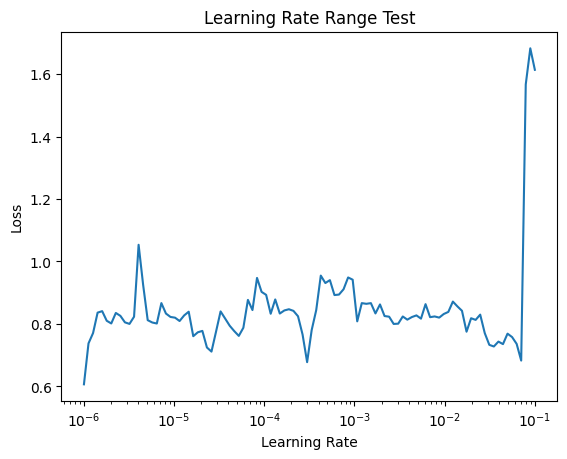

In [114]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the CNN model
def create_model():
    model = Sequential([
        Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train_pca.shape[1], 1)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        
        Conv1D(64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        
        Conv1D(32, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Adjust for multi-class if needed
    ])
    
    return model

# Prepare the data
X_train_cnn = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_test_cnn = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))

# Learning rate range test callback
class LearningRateRangeTest(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-6, max_lr=0.1, num_iters=100):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.num_iters = num_iters
        self.history = {}
        self.lrs = np.geomspace(self.min_lr, self.max_lr, num=self.num_iters)
    
    def on_train_begin(self, logs=None):
        self.iteration = 0
    
    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.iteration += 1
        
        lr = self.lrs[self.iteration - 1]
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        self.history.setdefault('lr', []).append(lr)
        
        if self.iteration >= self.num_iters:
            self.model.stop_training = True

# Create and compile the model
model = create_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate range test
lr_test = LearningRateRangeTest(num_iters=100)
history = model.fit(X_train_cnn, y_train, epochs=50, batch_size=8, callbacks=[lr_test])

# Plot the learning rate vs. loss
plt.plot(lr_test.history['lr'], lr_test.history['loss'])
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Range Test')
plt.show()


In [115]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
print(f'CNN Test Accuracy: {round(test_acc*100,3)} %')

1/1 [==============================] - 0s 217ms/step - loss: 0.7330 - accuracy: 0.5417
CNN Test Accuracy: 54.167 %


***Additional strategies to improve model perfomance***

1. Hyperparameter Tuning: Adjusting hyperparameters such as the learning rate, batch size, number of epochs, and architecture details to significantly impact model performance.

2. Extract more significant features from EEG data.

3. Data Augmentation: Though data augmentation is more common in image processing, certain techniques can be applied to EEG data, such as adding noise, time-shifting, and scaling.

4. Model Complexity: Increase the complexity of the model by adding more layers or units per layer.

5. Regularization Techniques: Implement regularization techniques like dropout, L2 regularization, and batch normalization to improve generalization.

6. Ensemble Methods: Combining predictions from multiple models can sometimes improve performance.

7. Transfer Learning: Utilize pre-trained models specifically designed for time-series data or adapt models from other domains.